In [43]:
from clusteringFunctions import *
from helpingFunctions import *
import pandas as pd
import os, re
from collections import Counter
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

In [44]:
csv_data = pd.read_csv('/Users/amycweng/Digital Humanities/sermons.csv')
all_info = pd.read_csv('/Users/amycweng/Digital Humanities/Early-Modern-London/Relevant_Metadata/charityTCP.csv')
tcpIDs = [ _ for _ in csv_data['id']]
idToTitle = {}
for idx, title in enumerate(all_info['title']):
    curr_id = all_info['id'][idx]
    if curr_id in tcpIDs: 
        idToTitle[curr_id] = title  
textInfo = getTexts('/Users/amycweng/Digital Humanities/charityTXT',tcpIDs,True)
print(len(textInfo))

transformer = TfidfTransformer(norm=None, sublinear_tf=True, use_idf=True)
vector = CountVectorizer()
word_counts = vector.fit_transform(textInfo.values())
tfidf_results = transformer.fit_transform(word_counts)
df = pd.DataFrame(tfidf_results.toarray(), index=textInfo.keys(), columns=vector.get_feature_names()) 

70


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


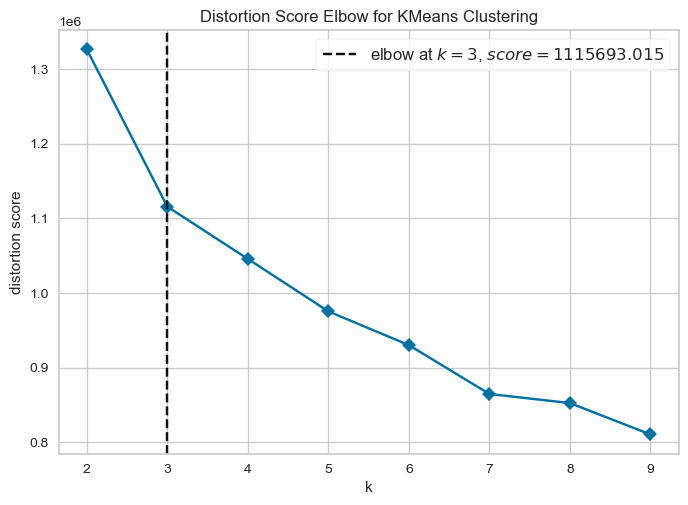

In [45]:
'''Clustering based only on the original texts (no other features)'''
elbow(df)

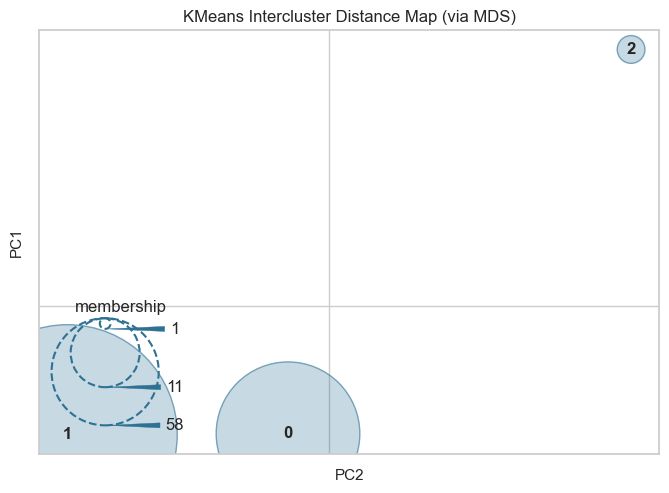

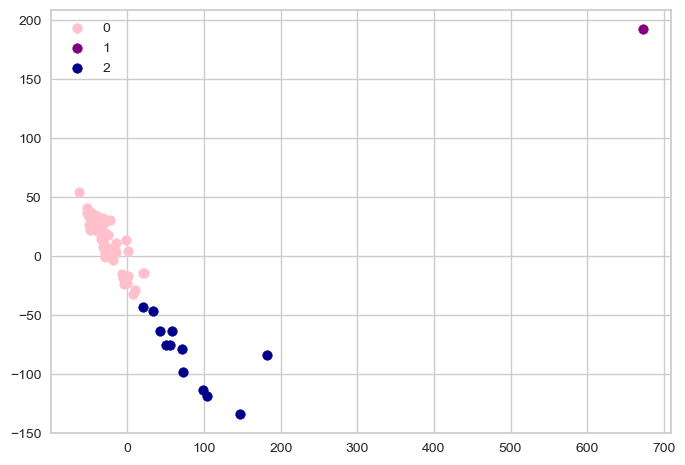

<Figure size 2000x1000 with 0 Axes>

In [46]:
intercluster(df,3)
groups = pca_cluster(df,3,tcpIDs,idToTitle,True)

In [61]:
def get_features(filePath,type): 
    '''
    Returns a dictionary in this format {id : features}
    '''
    readFile = open(filePath,'r')
    dict = {}
    for line in readFile:
        if type == 'citations': 
            tcpID =  line.split(' -- ')[0]
            features = line.split(' -- ')[1]
            features = re.sub('\n','',features)
            features = features.split('; ')
            if '' in features: features.remove('')
            dict[tcpID] = features
        else: 
            tcpID =  line.split(':')[0]
            features = line.split(':')[1]
            if type == 'topic' or type == 'ngrams': 
                features = re.sub('\n','',features)
                features = features.split(' ')
                if '' in features: features.remove('')
                dict[tcpID] = features
            elif type == 'subject': 
                final_features = []
                features = re.sub('\n','',features)
                features = features.split(' -- ')
                for feature in features: 
                    if not re.search('Sermons\, English|Early works to 1800.|17th century.|Sermons.|Sermons|Bible.',feature):
                        final_features.append(feature.strip())
                if '' in features: final_features.remove('')
                dict[tcpID] = final_features
    readFile.close()
    return dict

def count_features(feature_dict,ids,type=''): 
    all_features = []
    for tcpID, features in feature_dict.items(): 
        if tcpID in ids and len(features) > 0: 
            all_features.extend(features)
    if type == 'all citations': 
        print(f'\tThere are {len(all_features)} marginal citations in total.')
    elif type == 'charity citations': 
        print(f'\tThere are {len(all_features)} marginal citations relating to charity.')

    return Counter(all_features).most_common(n=20)

def all_tfidf(tcpIDs):
    tfidf_list = []
    for tcpID in tcpIDs: 
        single_text_df = pd.DataFrame(tfidf_results[[_ for _ in textInfo.keys()].index(tcpID)].T.todense(), index=vector.get_feature_names(), columns=[tcpID])
        single_text_df = single_text_df.sort_values(tcpID, ascending=False)
        top_tfidf = list(single_text_df.head(25).T.columns)
        tfidf_list.extend(top_tfidf)
    return(tfidf_list)

In [66]:
tcpID = 'A55754'
single_text_df = pd.DataFrame(tfidf_results[[_ for _ in textInfo.keys()].index(tcpID)].T.todense(), index=vector.get_feature_names(), columns=[tcpID])
single_text_df = single_text_df.sort_values(tcpID, ascending=False)
top_tfidf = list(single_text_df.head(25).T.columns)
print(top_tfidf)

from sklearn.feature_extraction.text import TfidfVectorizer
vector = TfidfVectorizer()
tfidf_results = vector.fit_transform(textInfo.values())
single_text_df = pd.DataFrame(tfidf_results[[_ for _ in textInfo.keys()].index(tcpID)].T.todense(), index=vector.get_feature_names(), columns=[tcpID])
single_text_df = single_text_df.sort_values(tcpID, ascending=False)
top_tfidf = list(single_text_df.head(25).T.columns)
print(top_tfidf)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['arminius', 'execration', 'stafford', 'preston', 'fullness', 'accurse', 'maranatha', 'anathema', 'treatise', 'sup', 'hater', 'dominion', 'forgive', 'sabboath', 'dd', 'love', 'aswell', 'godliness', 'ebal', 'tabor', 'olivet', 'matthew', 'spouse', 'god', 'sign']
['love', 'god', 'lord', 'sin', 'christ', 'heart', 'grace', 'fullness', 'take', 'good', 'give', 'power', 'jesus', 'godliness', 'faith', 'spirit', 'desire', 'receive', 'believe', 'forgive', 'accurse', 'show', 'curse', 'work', 'keep']


In [58]:
important_info = pd.read_csv('/Users/amycweng/Digital Humanities/Early-Modern-London/Sermons_Info/audience.location.etc.csv')
location, audience, help_poor = {}, {}, {}
for idx, tcpID in enumerate(important_info['id']):
    location[tcpID] = [important_info['location_name'][idx]]
    audience[tcpID] = [important_info['audience'][idx]]
    help_poor[tcpID] = [important_info['help_poor'][idx]]

In [62]:
topics = get_features('/Users/amycweng/Digital Humanities/Early-Modern-London/Sermons_Info/topics.charity.sermons.txt','topic')
subjects = get_features('/Users/amycweng/Digital Humanities/Early-Modern-London/Sermons_Info/sermons.subject.headings.txt','subject')
all_citations = get_features('/Users/amycweng/Digital Humanities/Early-Modern-London/Sermons_Info/marginalia.all.sermons.txt','citations')
charity_citations = get_features('/Users/amycweng/Digital Humanities/Early-Modern-London/Sermons_Info/marginalia.charity.sermons.txt','citations')
ngrams = get_features('/Users/amycweng/Digital Humanities/Early-Modern-London/Sermons_Info/gramsEachcharityText.txt','ngrams')

In [63]:
for groupNum, ids_list in groups.items(): 
    if len(ids_list) == 1:
        print(f'There is {len(ids_list)} text in Group {groupNum}')
    else: 
        print(f'There are {len(ids_list)} texts in Group {groupNum}')
    print(f'Group {groupNum} TCP IDs: {ids_list}')
    print(f'\tThe locations for the texts in this cluster: {count_features(location,ids_list)}')
    print(f'\tThe audiences for the texts in this cluster: {count_features(audience,ids_list)}')
    print(f'\tWhether or not the text mentions the provision of material help to the needy: {count_features(help_poor,ids_list)}')
    print(f'\tHere are the top 20 TFIDF terms for the texts within this cluster: {Counter(all_tfidf(ids_list)).most_common(n=20)}')

    print(f'\tTop 20 Bigrams and Trigrams of Keywords: {count_features(ngrams,ids_list)}')
    print(f'\tTop 20 Topic Words: {count_features(topics,ids_list)}')
    print(f'\tTop 20 subject headings: {count_features(subjects,ids_list)}')

    print(f'\t\tTop 20 Biblical/Apocryphal Citations: {count_features(all_citations,ids_list,"all citations")}')
    print(f'\t\tTop 20 Biblical/Apocryphal Citations Relating to Charity: {count_features(charity_citations,ids_list,"charity citations")}.\n\n')

There are 12 texts in Group 2
Group 2 TCP IDs: ['A68088', 'A41670', 'A55748', 'A10010', 'A09958', 'A86974', 'A01533', 'A70130', 'A01530', 'A02591', 'A15010', 'A15012']
	The locations for the texts in this cluster: [("St. Mary's Church, Banbury", 2), ('London', 1), ('St Ann Blackfriars', 1), ("Lincoln's Inn or Cambridge", 1), ("Lincoln's Inn", 1), ('Holy Trinity Church, Cambridge', 1), ('Palace of Whitehall', 1), ("Sergeant's Inn", 1), ("St. Paul's Church", 1), ('Tonbridge Free School', 1), ('Theobalds Palace', 1)]
	The audiences for the texts in this cluster: [('local', 7), ('monarch', 2), ('funeral', 1), ('historical', 1), ('school', 1)]
	Whether or not the text mentions the provision of material help to the needy: [(True, 7), (False, 5)]
	Here are the top 20 TFIDF terms for the texts within this cluster: [('disobedience', 2), ('injustice', 2), ('threat', 2), ('dissolution', 1), ('death', 1), ('departure', 1), ('dine', 1), ('port', 1), ('mortality', 1), ('desirable', 1), ('access', 1)